# PHYS 3009: TeV Gamma-Ray Data Analysis with GammaPy

This jupyter notebook presents a quick analysis of H.E.S.S. observations of the Crab Nebula. The data set is part of the first public test data release. You can find more information here: https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/

The analysis is performed using gammapy, a community-developed, open-source Python package for gamma-ray astronomy (https://docs.gammapy.org/). More information on the individual data analysis steps can be found in the gammapy tutorials: https://docs.gammapy.org/1.1/tutorials/index.html

# 1. First Look at the Data

## Data download
The following lines check the setup and download the data.

### import
The next cell executes the imports necessary for this project.

In [1]:
from gammapy.utils.check import check_tutorials_setup

In [2]:
from gammapy.data import DataStore

In [3]:
# end import

In [4]:
check_tutorials_setup()

201MB [00:19, 10.6MB/s]                                                         



*** You might want to declare GAMMAPY_DATA env variable
export GAMMAPY_DATA=gammapy-data/1.1


System:

	python_executable      : /home/komin/anaconda3/envs/gammapy-1.1/bin/python 
	python_version         : 3.9.16     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.1        
	path                   : /home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.24.3     
	scipy                  : 1.10.1     
	astropy                : 5.3        
	regions                : 0.7        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.7.0      
	jupyterlab             : 3.5.3      
	matplotlib             : 3.7.1      
	pandas                 : 1.5.2      
	healpy                 : 1.16.2     
	iminuit                : 2.21.3     
	sherpa                 : 4.15.1     
	naima                  : 0.10.

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/1.1/hess-dl3-dr1")

In [6]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: gammapy-data/1.1/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



Expected output:

```
Data store:
HDU index table:
BASE_DIR: gammapy-data/1.1/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105
```

## Run Selection

### imports

In [7]:
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

In [8]:
# end imports

We set the source position. frame='icrs' indicates that we are using coordinates in right ascension and declination.

In [9]:
source_pos = SkyCoord(83.633*u.deg, 22.014*u.deg, frame='icrs')

In [10]:
selectradius = 2.5*u.deg

In [11]:
conesearch = data_store.obs_table.select_sky_circle(source_pos, selectradius)

In [12]:
conesearch

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
23523,83.63333,21.514444,184.9823,-6.0516925,48.61021,41.38979,22.481705,Crab Nebula,83.63333,22.014444,0.5,1687.0,1581.7368,0.9376033,123890826.0,123892513.0,2004-12-04,22:08:10.184,2004-12-04,22:36:17.184,4,"1,2,3,4",0,0.9070748,7613,Crab,crab,0.500049,0.8709636,100.0
23526,83.63333,22.514444,184.13332,-5.5163794,45.77929,44.22071,8.542603,Crab Nebula,83.63333,22.014444,0.5,1683.0,1572.6868,0.9344544,123893580.0,123895263.0,2004-12-04,22:54:04.184,2004-12-04,23:22:07.184,4,"1,2,3,4",0,0.9142412,7581,Crab,crab,0.49995112,0.70794576,100.0
23559,85.253334,22.014444,185.35727,-4.510869,45.368176,44.631824,2.2535799,Crab Nebula,83.63333,22.014444,1.5018803,1686.0,1578.1235,0.9360163,124067051.0,124068737.0,2004-12-06,23:05:15.184,2004-12-06,23:33:21.184,4,"1,2,3,4",0,0.91964024,7601,Crab,crab,1.5021166,0.66069347,100.0
23592,82.013336,22.014444,183.7408,-7.047852,48.389248,41.610752,21.7556,Crab Nebula,83.63333,22.014444,1.5018733,1686.0,1581.2646,0.9378794,124235636.0,124237322.0,2004-12-08,21:55:00.184,2004-12-08,22:23:06.184,4,"1,2,3,4",0,0.9120389,7334,Crab,crab,1.5016365,0.8709636,100.0


In [13]:
runlist = conesearch['OBS_ID'].value

In [14]:
print(runlist)

[23523 23526 23559 23592]


In [15]:
len(runlist)

4

In [16]:
observations = data_store.get_observations(runlist)

We create a dictionary where we will store final results which we produce along the way.

In [17]:
final_results = {}

Let's add some information to our results:

In [18]:
final_results['run list'] = runlist

## Event List

Let's have a look at the event list of one single run. We will use run number 23523.

In [19]:
runno = '23523'

### imports

In [20]:
from gammapy.data import EventList

import matplotlib.pyplot as plt

In [21]:
# end imports

In [22]:
events = observations[runno].events

In [23]:
print(events)

EventList
---------

  Instrument       : H.E.S.S. Phase I
  Telescope        : HESS
  Obs. ID          : 23523

  Number of events : 7613
  Event rate       : 4.513 1 / s

  Time start       : 53343.92234009259
  Time stop        : 53343.94186555556

  Min. energy      : 2.44e-01 TeV
  Max. energy      : 1.01e+02 TeV
  Median energy    : 9.53e-01 TeV

  Max. offset      : 58.0 deg



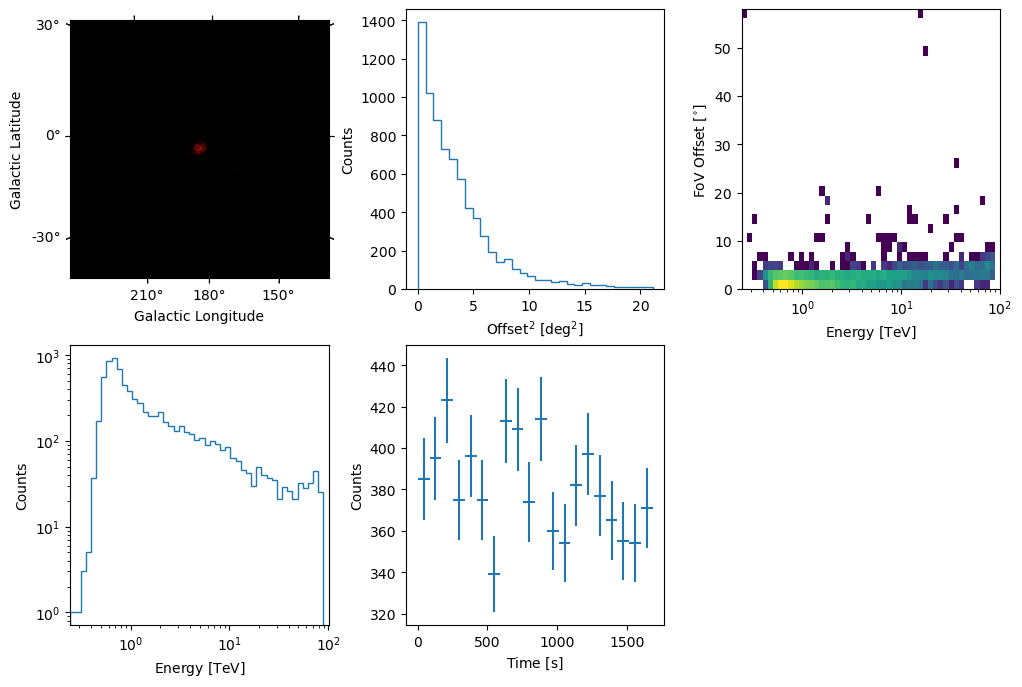

In [24]:
events.peek()

In [25]:
events.table

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
5407363825684,123890826.66805482,84.97964,23.89347,10.352011
5407363825695,123890826.69749284,84.54751,21.004095,4.0246882
5407363825831,123890827.23673964,85.39696,19.41868,2.2048872
5407363825970,123890827.79615426,81.93147,20.79867,0.69548655
5407363826067,123890828.26131463,85.98302,21.053099,0.86911184
5407363826095,123890828.41393518,86.97305,21.837437,4.1240892
...,...,...,...,...
7198365188619,123892512.01627827,81.832565,20.889784,0.79988396


(array([[0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
         1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 3.000e+00, 2.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
         7.000e+00, 1.264e+03, 1.245e+03, 4.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
         1.000e+01, 2.438e+03, 2.615e+03, 7.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
         1.000e+00, 2.

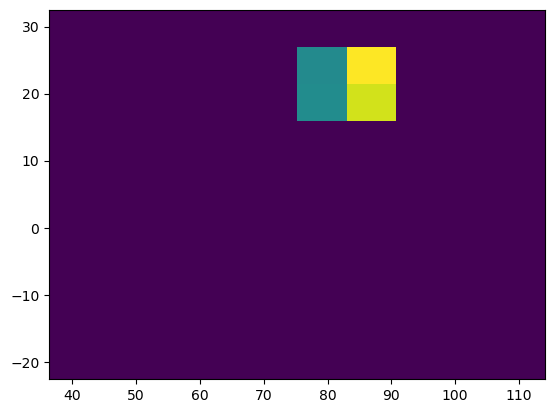

In [26]:
plt.hist2d(events.table['RA'], 
           events.table['DEC'], 
           #bins = [100,100]
          )

(array([6.957e+03, 2.730e+02, 1.230e+02, 5.800e+01, 4.700e+01, 4.800e+01,
        3.600e+01, 5.200e+01, 1.800e+01, 1.000e+00]),
 array([  0.24408458,  10.31748962,  20.39089394,  30.46430016,
         40.53770447,  50.61111069,  60.68451309,  70.75791931,
         80.83132172,  90.90473175, 100.97813416]),
 <BarContainer object of 10 artists>)

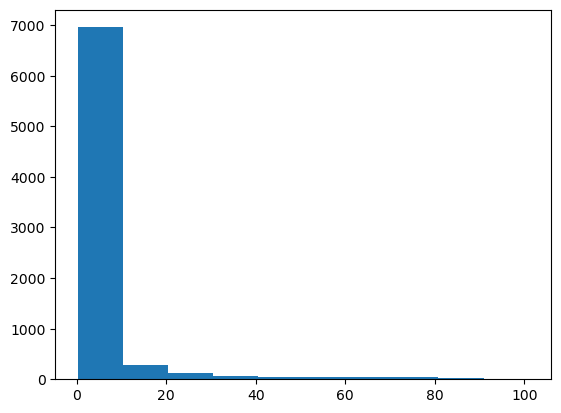

In [27]:
plt.hist(events.table['ENERGY'],
         #log = True,
         #range = [0.1,100],
         #bins = 100,
        )

## Theta$^2$ Plot

### on-source counts

In [28]:
events.radec

<SkyCoord (ICRS): (ra, dec) in deg
    [(84.97964, 23.89347 ), (84.54751, 21.004095), (85.39696, 19.41868 ),
     ..., (81.45052, 22.960012), (84.41192, 21.330505),
     (84.47432, 21.634737)]>

In [29]:
first_event = events.radec[0]

In [30]:
first_event

<SkyCoord (ICRS): (ra, dec) in deg
    (84.97963715, 23.89347076)>

In [31]:
first_event.separation(source_pos)

<Angle 2.25162464 deg>

In [32]:
theta2 = events.radec.separation(source_pos)**2

In [33]:
print(theta2)

[5.069807   1.7437685  9.457167   ... 4.9611506  0.99111927 0.7538241 ] deg2


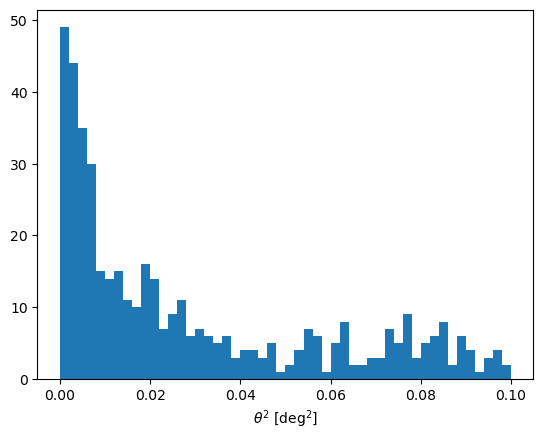

In [34]:
ret = plt.hist(theta2.value, 
               range = [0,0.1], 
               bins = 50
              )

plt.xlabel('$\\theta^2$ [deg$^2$]')

plt.savefig('Theta2_on.svg')

In [35]:
ret

(array([49., 44., 35., 30., 15., 14., 15., 11., 10., 16., 14.,  7.,  9.,
        11.,  6.,  7.,  6.,  5.,  6.,  3.,  4.,  4.,  3.,  5.,  1.,  2.,
         4.,  7.,  6.,  1.,  5.,  8.,  2.,  2.,  3.,  3.,  7.,  5.,  9.,
         3.,  5.,  6.,  8.,  2.,  6.,  4.,  1.,  3.,  4.,  2.]),
 array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
        0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
        0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
        0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
        0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  ]),
 <BarContainer object of 50 artists>)

In [36]:
n = ret[0]
x = ret[1]

In [37]:
print(x)

[0.    0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022
 0.024 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044 0.046
 0.048 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.064 0.066 0.068 0.07
 0.072 0.074 0.076 0.078 0.08  0.082 0.084 0.086 0.088 0.09  0.092 0.094
 0.096 0.098 0.1  ]


In [38]:
x[1:]<0.01

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [39]:
n[ x[1:]<0.01 ]

array([49., 44., 35., 30., 15.])

In [40]:
oncounts = n[x[1:]<0.01].sum()

In [41]:
oncounts

173.0

In [42]:
final_results['on counts'] = oncounts

### off-source counts

In [43]:
obs = observations[runno]

In [44]:
print(obs)

Observation

	obs id            : 23523 
 	tstart            : 53343.92
	tstop             : 53343.94
	duration          : 1687.00 s
	pointing (icrs)   : 83.6 deg, 21.5 deg

	deadtime fraction : 6.2%



In [45]:
obs.pointing_radec

/tmp/ipykernel_40157/2338083612.py:1: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  obs.pointing_radec
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/utils/decorators.py:837: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)


<SkyCoord (ICRS): (ra, dec) in deg
    (83.63333333, 21.51444444)>

In [46]:
separation = obs.pointing_radec.separation(source_pos)
print (separation)

0d29m58.40034531s


/tmp/ipykernel_40157/3238534179.py:1: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  separation = obs.pointing_radec.separation(source_pos)


In [47]:
position_angle = obs.pointing_radec.position_angle(source_pos)
print (position_angle.to(u.deg))

359d57m52.40063811s


/tmp/ipykernel_40157/883252326.py:1: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  position_angle = obs.pointing_radec.position_angle(source_pos)


In [48]:
offpos = obs.pointing_radec.directional_offset_by( position_angle+180*u.deg, separation)

/tmp/ipykernel_40157/3775772750.py:1: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  offpos = obs.pointing_radec.directional_offset_by( position_angle+180*u.deg, separation)


In [49]:
offpos

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63366438, 21.01488889)>

In [50]:
theta2_off = events.radec.separation(offpos)**2

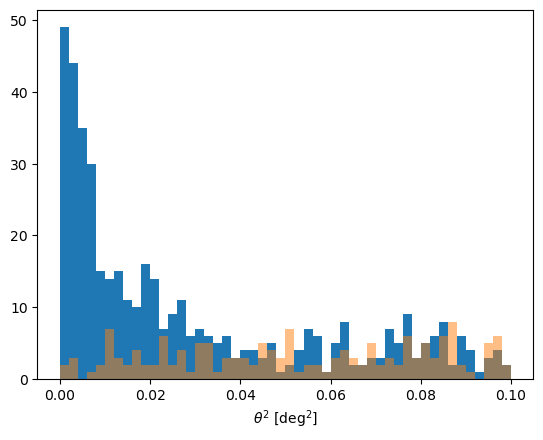

In [51]:
plt.hist(theta2.value, range = [0,0.1], bins = 50)
ret_off = plt.hist(theta2_off.value, range = [0,0.1], bins = 50, alpha = 0.5)

plt.xlabel('$\\theta^2$ [deg$^2$]')

plt.savefig('Theta2_onoff.svg')

In [52]:
n_off = ret_off[0]
offcounts = n_off[x[1:]<0.01].sum()

In [53]:
print(oncounts,offcounts)

173.0 8.0


In [54]:
final_results['off counts'] = offcounts

### excess

In [55]:
excess = oncounts - offcounts

In [56]:
excess

165.0

In [57]:
final_results['excess'] = excess

### background check

Let's check that there is no excess at larger $\theta^2$ values, where we do not expect any emission.

In [58]:
x[1:] > 0.05

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [59]:
check_on = n[x[1:]>0.05].sum()

In [60]:
check_off = n_off[x[1:]>0.05].sum()

In [61]:
print('{} - {} = {}'.format(check_on, check_off, check_on - check_off))

109.0 - 87.0 = 22.0


## Significance

In [62]:
total = oncounts + offcounts

In [63]:
total

181.0

In [64]:
#from math import sqrt

from numpy import sqrt

In [65]:
sigma = sqrt(total)

In [66]:
sigma

13.45362404707371

In [67]:
significance_1 = excess/sigma

In [68]:
significance_1

12.264353413078245

In [69]:
from gammapy.stats import WStatCountsStatistic

In [70]:
stat = WStatCountsStatistic(n_on=oncounts, n_off=offcounts, alpha=1.)

print('excess: {} \nsignificance: {}'.format(stat.n_sig,stat.sqrt_ts))

excess: 165.0 
significance: 13.615186756250544


Let's check the background:

In [71]:
stat_check = WStatCountsStatistic(n_on=check_on, n_off=check_off, alpha=1.)

print('excess: {} \nsignificance: {}'.format(stat_check.n_sig,stat_check.sqrt_ts))

excess: 22.0 
significance: 1.5730859267652315


## Your playground

If you want to do it yourself, try the following.

Make a theta^2 plot for signal and background for run no. 23523. Calculate the number of on and off events for a theta^2 cut of 0.02. Calculate the significance.

In [72]:
## your code here

## Summary

That's all. Let's see what we have.

In [74]:
final_results

{'run list': array([23523, 23526, 23559, 23592]),
 'on counts': 173.0,
 'off counts': 8.0,
 'excess': 165.0}